In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from matplotlib.patches import Rectangle
import re
sns.set()

# Introduction <a id='intro'></a>

This notebook uses a variety of different COVID-19 related datasets to explore the behavior
of the multiple time series'. This notebook also creates new features that attempt to encapsulate the
time dependent (and time delayed) nature of the problem; these will be used during the model creation
project which makes time dependent forecasting models. 


# Table of contents

## [Function definitions](#generalfunctions)

## [Data](#imports)

## [Exploratory Data Analysis](#EDA)

## [Feature production](#newfeatures)

## Function definitions <a id='generalfunctions'></a>

In [432]:
def rolling_means(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values 
        rollmean = pd.DataFrame(df.groupby(by='location').rolling(window).mean().fillna(value=0.))
#         rollstd = pd.DataFrame(df.groupby(by='location').rolling(window).std().fillna(value=0.))    
#         new_features = pd.concat((rollmean, rollstd), axis=1)
        new_features = rollmean
        new_cols = features +'_rolling_mean_' + str(window)
#         rsind = features +'_rolling_std_' + str(window)
#         new_cols = rmind.append(rsind)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
    return new_feature_df_list

def tsplot(data, roll_width, **kw):
    rollmean = datatmp.rolling(roll_width).mean().fillna(method='backfill').values.ravel()
    rollstd  = datatmp.rolling(roll_width).std().fillna(method='backfill').values.ravel()
    cis = (rollmean - rollstd, rollmean + rollstd)
    fig, ax = plt.subplots()
    ax.fill_between(range(len(datatmp)), cis[0], cis[1], alpha=0.5)
    ax.plot(range(len(datatmp)), rollmean, color='k', **kw)
    return ax

def reformat_values(values_to_transform, category='columns',dateformat=None):
    """ Reformat column and index names. 
    
    Parameters :
    ----------
    df : Pandas DataFrame
    columns : bool
    index : bool
    
    Notes :
    -----
    Change headers of columns; this needs to be updated to account for their formatting changes. 
    This function converts strings with CamelCase, underscore and space separators to lowercase words uniformly
    separated with underscores. I.e. (hopefully!) following the correct python identifier syntax so that each column
    can be reference as an attribute if desired. 

    For more on valid Python identifiers, see:
    https://docs.python.org/3/reference/lexical_analysis.html#identifiers
    """
    
    """ Reformat column and index names. only works with with pandas MultiIndex for level=0.
    
    Parameters :
    ----------
    df : Pandas DataFrame

    Notes :
    -----
    Different datasets have different naming conventions (for countries that go by multiple names and abbreviations).
    This function imposes a convention on a selection of these country names.  
    """
    # these lists are one-to-one. countries compared via manual inspection, unfortunately. 
    mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China',
                           'Occupied Palestinian Territory','Republic of Korea', 'Korea, South', 
                           'Gambia, The ', 'UK', 
                           'USA', 'Iran (Islamic Republic of)',
                           'Bahamas, The', 'Russian Federation', 'Czech Republic', 'Republic Of Ireland',
                          'Hong Kong Sar', 'Macao Sar', 'Uk','Us',
                           'Congo ( Kinshasa)','Congo ( Brazzaville)',
                           'Cote D\' Ivoire', 'Viet Nam','Guinea- Bissau','Guinea','Usa']

    mismatch_labels_good = ['Laos','China',
                            'Palestine', 'South Korea', 'South Korea', 
                            'The Gambia', 'United Kingdom', 
                            'United States','Iran',
                            'The Bahamas','Russia','Czechia','Ireland',
                            'Hong Kong','Macao','United Kingdom', 'United States',
                            'Democratic Republic Of The Congo','Republic Of The Congo',
                            'Ivory Coast','Vietnam', 'Guinea Bissau','Guinea Bissau','United States']
    
    # three cases, column names, country names, or datetime. 
    if category == 'location':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append(' '.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                        re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val).lower())
                                                        .split()).title())
        transformed_values = pd.Series(reformatted_values).replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
    
    elif category == 'columns':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append('_'.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                     re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val)
                                                            .lower()).split()))
        transformed_values = pd.Series(reformatted_values)
        
    elif category == 'date':
        transformed_values = pd.to_datetime(pd.Series(
            values_to_transform), errors='coerce',format=dateformat).dt.normalize()


    return transformed_values


def column_search(df, name):
    return df.columns[df.columns.str.contains(name)]

def country_groupby_indices_list(df):
    return [df[df.location==country].index for country in df.location.unique()]


def regularize_names(df, datekey=None, locationkey=None, dateformat=None):
    df.columns = reformat_values(df.columns, category='columns').values
    if datekey is not None:
        df.loc[:, 'date'] = reformat_values(df.loc[:, datekey], category='date', dateformat=None).values
    if locationkey is not None:
        df.loc[:, 'location'] =  reformat_values(df.loc[:, locationkey], category='location').values
    return df

def reformat_values(values_to_transform, category='columns',dateformat=None):
    """ Reformat column and index names. 
    
    Parameters :
    ----------
    df : Pandas DataFrame
    columns : bool
    index : bool|
    
    Notes :
    -----
    Change headers of columns; this needs to be updated to account for their formatting changes. 
    This function converts strings with CamelCase, underscore and space separators to lowercase words uniformly
    separated with underscores. I.e. (hopefully!) following the correct python identifier syntax so that each column
    can be reference as an attribute if desired. 

    For more on valid Python identifiers, see:
    https://docs.python.org/3/reference/lexical_analysis.html#identifiers
    """
    
    """ Reformat column and index names. only works with with pandas MultiIndex for level=0.
    
    Parameters :
    ----------
    df : Pandas DataFrame

    Notes :
    -----
    Different datasets have different naming conventions (for countries that go by multiple names and abbreviations).
    This function imposes a convention on a selection of these country names.  
    """
    # these lists are one-to-one. countries compared via manual inspection, unfortunately. 
    mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China',
                           'Occupied Palestinian Territory','Republic of Korea', 'Korea, South', 
                           'Gambia, The ', 'UK', 
                           'USA', 'Iran (Islamic Republic of)',
                           'Bahamas, The', 'Russian Federation', 'Czech Republic', 'Republic Of Ireland',
                          'Hong Kong Sar', 'Macao Sar', 'Uk','Us',
                           'Congo ( Kinshasa)','Congo ( Brazzaville)',
                           'Cote D\' Ivoire', 'Viet Nam','Guinea- Bissau','Guinea','Usa']

    mismatch_labels_good = ['Laos','China',
                            'Palestine', 'South Korea', 'South Korea', 
                            'The Gambia', 'United Kingdom', 
                            'United States','Iran',
                            'The Bahamas','Russia','Czechia','Ireland',
                            'Hong Kong','Macao','United Kingdom', 'United States',
                            'Democratic Republic Of The Congo','Republic Of The Congo',
                            'Ivory Coast','Vietnam', 'Guinea Bissau','Guinea Bissau','United States']
    
    # three cases, column names, country names, or datetime. 
    if category == 'location':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append(' '.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                        re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val).lower())
                                                        .split()).title())
        transformed_values = pd.Series(reformatted_values).replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
    
    elif category == 'columns':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append('_'.join(re.sub('([A-Z][a-z]+)', r' \1', 
                                                     re.sub('([A-Z]+)|_|\/|\)|\(', r' \1', val)
                                                            .lower()).split()))
        transformed_values = pd.Series(reformatted_values)
        
    elif category == 'date':
        transformed_values = pd.to_datetime(pd.Series(
            values_to_transform), errors='coerce',format=dateformat).dt.normalize()


    return transformed_values

def add_time_indices(data_table):
    n_cases_pos = data_table.loc[:,'new_cases'].replace(to_replace=0, value=np.nan).dropna().reset_index()
    country_groupby_indices = country_groupby_indices_list(data_table)
    country_groupby_indices_dropped_nan = country_groupby_indices_list(n_cases_pos)
    days_since = []
    for i, c in enumerate(country_groupby_indices_dropped_nan):
        nonzero_list = list(range(len(c)))
        zero_list = 0*np.array(list(range(len(country_groupby_indices[i])-len(c))))
        days_since += list(zero_list)+nonzero_list

    data_table.loc[:, 'time_index'] = days_since
    data_table.loc[:, 'date_proxy'] = len(data_table.location.unique())*list(range(len(data_table.date.unique())))
    return data_table

## Data <a id='imports'></a>

Differences in reporting
Differences in government responses
differences in time series.

testing vs cases vs deaths
log-log plot for current growth trends
bollinger bands
histogram of trending upwards, flat, downwards
tools, different plots, correlation plots scatter matrix plots. 

Going to remove microstates like San Marino. 

In [452]:
data = pd.read_csv('eda_data.csv', index_col=0)
data.sample(5)

,location,date,cases_jhucsse,deaths_jhucsse,recovered_jhucsse,country_region_jhucsse_reports,confirmed_jhucsse_reports,deaths_jhucsse_reports,recovered_jhucsse_reports,latitude_jhucsse_reports,...,cases_ttc,new_cases_ttc,deaths_ttc,cases_per100k_ttc,deaths_per100k_ttc,new_tests_ttt,tests_cumulative_ttt,tests_per100k_ttt,time_index,date_proxy
11816,Pakistan,2020-04-29,15525,343,3425,Pakistan,14612.0,312.0,3233.0,NaN,...,15525.0,913.0,343.0,7.0,0.2,8688.0,165911.0,75.1,63,98
522,Argentina,2020-02-09,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18
15261,Thailand,2020-02-06,25,0,5,NaN,NaN,NaN,NaN,NaN,...,25.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,15,15
4010,Costa Rica,2020-05-05,755,6,413,Costa Rica,742.0,6.0,399.0,NaN,...,755.0,13.0,6.0,14.8,0.1,0.0,13851.0,271.9,60,104
6288,Germany,2020-05-15,175233,7897,151597,Germany,33804.0,1629.0,29400.0,NaN,...,175233.0,755.0,7897.0,209.1,9.4,0.0,3147771.0,3757.0,109,114


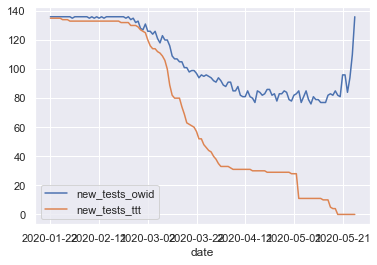

In [453]:
data.set_index(['location', 'date']).isna().groupby(level=1).sum().loc[:, column_name_search(data, 'new_test')].iloc[:,[0,-1]].plot()

Estimation of actual death rates, assuming 50% of people are asymptomatic and do not actually get tested.

today_data = data[data.date_proxy == data.date_proxy.max()]

today_data.loc[:, 'estimation_death_rate'] = 100 * today_data.loc[:, 'deaths_jhucsse'].values / (2. * today_data.loc[:, 'cases_jhucsse'].values)

(weighted_dr).plot.hist(bins=50)

data.loc[:,column_name_search(data, 'long').tolist() + column_name_search(data, 'lat').tolist()].iloc[:, [1,3]].plot.hist()

data.loc[:, 'population_owid'] = data.loc[:, 'population_owid'].fillna(method='bfill').fillna(method='ffill')
data.loc[:, 'population_density_owid'] = data.loc[:, 'population_density_owid'].fillna(method='bfill').fillna(method='ffill')

Reporting inconsistencies

In [459]:
data.loc[:, 'new_cases_per_million_owid'] = data.loc[:, 'new_cases_owid'] / (data.loc[:, 'population_owid'] / 1000000.)
data.loc[:, 'new_cases_per_million_ttc'] = data.loc[:, 'new_cases_ttc'] / (data.loc[:, 'population_owid'] / 1000000.)

ax = (data.groupby('location').sum().loc[:, ['new_cases_per_million_ttc','new_cases_per_million_owid']].diff(axis=1)).plot(label='tt')
# data.groupby('location').sum().loc[:, 'new_cases_per_million_owid'].plot(ax=ax, label='owid')
plt.legend()

In [461]:
# # key words account for multilevel indices
# data = pd.read_csv('data.csv', index_col=[0,1], header=[0,1])
# data.sample(5)

## Feature production <a id='newfeatures'></a>

function ```append_rolling_values``` is not working. Need to compute rolling averages for each
countries time series' individually but want to store them in the multi index DataFrame. 



Before interpolation and backfilling, I used to prune countries which did not have cases prior
to responses (i.e. "early responders" were not included)
To make my life easier, I'm only taking data which had cases before all government mandates so the rates before and after are well defined. We can think of these as being "late responders"

In [462]:
initial_response_data = data.replace(to_replace=[0,0.], value=np.nan)

In [463]:
time_dependent= model_data.set_index('location').loc[:, :'time_index'].iloc[:, :-2].reset_index()
time_independent = model_data.loc[:, 'time_index':'cvd_death_rate'].iloc[:, 1:].fillna(0)#.columns
flag_and_misc = model_data.loc[:, 'c1_flag_0':'date']

roll_widths = [3, 7, 14]
# roll_widths = list(range(2,15))


rolling_predictors = rolling_features(time_dependent, time_dependent.columns.drop('location'), roll_widths)
# This drops the first category, Afghanistan.
location_one_hot = pd.get_dummies(model_data.loc[:, 'location'], drop_first=True)
# this specifically drops the NaN category
tests_units_one_hot = pd.get_dummies(model_data.loc[:, 'tests_units'])
tests_units_one_hot.columns = 'test_units_' + reformat_values(tests_units_one_hot, category='columns')

KeyError: 'hospital_beds_per_100k'

In [465]:
df = pd.concat((data.loc[:, 'date_proxy':'time_index'], time_dependent.drop(columns='location'), 
                pd.concat(rolling_predictors, axis=1).reset_index(drop=True), time_independent,
                   location_one_hot, tests_units_one_hot, flag_and_misc),axis=1)

NameError: name 'rolling_predictors' is not defined

In [464]:
df[df.location=='United States'].loc[:, df.columns[df.columns.str.contains('new_cases')]].plot(legend=False, figsize=(10,10))

NameError: name 'df' is not defined

Data has the following partitions:

columns until and not including 'population' are time series variables.
        'population':'Albania' : time independent, continuous variables
        'Albania':'location' : one-hot encoded variables
        'location:' location and date, not encoded.
        
Time series variables with drift as baseline model : any columns with 'new' (cases, deaths, tests)
Time series variables with naive as baseline model : The complement to the drift baseline variables. 


## Exploratory Data Analysis<a id='EDA'></a>
Ideas for the inclusion or creation of new columns.

Moving averages
fourier
signal
flags for lots of different things

hardest hit countries

days since

extrapolated, actual, interpolated

which dataset it came from

humans view, interpret and forecast things in a way which are not available to robots. 
data driven, time dependent manner of modeling. Really trying to encapsulate the time dependence. 

In [469]:
government_responses = pd.concat((data.loc[:, ['location','date']],
                                  data.loc[:, column_search(data, 'oxcgrt')].drop(
                                      columns=column_search(data, 'flag')).iloc[:,2:10]), axis=1)

government_responses = regularize_names(pd.read_csv('OxCGRT_latest.csv'), locationkey='country_name')
government_responses.loc[:, 'date'] = pd.to_datetime(government_responses.loc[:, 'date'], format='%Y%m%d')
# oxcgrt_df = oxcgrt_df.set_index(['location', 'date'])
# oxcgrt_df = oxcgrt_df.drop(columns='m1_wildcard')

government_responses = pd.concat((government_responses.loc[:, ['location', 'date']], government_responses.iloc[:,3:18:2]), axis=1)

government_responses.loc[:, 'date'] = government_responses.date.dt.normalize().values



countries_with_all_responses = None
for i, country_indices in enumerate(country_groupby_indices_list(government_responses)):
    government_responses.loc[country_indices,:] = government_responses.loc[country_indices,:].fillna(method='ffill')
    has_all_flags = (government_responses.loc[country_indices,:].max() == 0).sum()
    if has_all_flags != 0:
        pass
    else:
        if countries_with_all_responses is None:
            countries_with_all_responses = government_responses.loc[country_indices,:]
        else:
            countries_with_all_responses = pd.concat((countries_with_all_responses, government_responses.loc[country_indices,:]),axis=0)

# government_responses = government_responses.dropna(axis=0).iloc[:,:10]

countries_with_all_responses.loc[:, 'date'] = pd.to_datetime(countries_with_all_responses.date).dt.normalize()

see_if_country_samples =countries_with_all_responses.groupby('location').count().sort_values(by='date') 
drop_these_countries = np.unique(np.where(~(see_if_country_samples == 148))[0])
countries_with_all_responses = countries_with_all_responses[countries_with_all_responses.location != 'Kosovo']

def add_time_indices(data_table, index_column='cases'):
    indexer = data_table.loc[:, ['location',index_column]].replace(to_replace=0, value=np.nan).dropna().reset_index()
    country_groupby_indices = country_groupby_indices_list(data_table)
    country_groupby_indices_dropped_nan = country_groupby_indices_list(indexer)
    days_since = []
    for i, c in enumerate(country_groupby_indices_dropped_nan):
        nonzero_list = list(range(len(c)))
        zero_list = 0*np.array(list(range(len(country_groupby_indices[i])-len(c))))
        days_since += list(zero_list)+nonzero_list

    data_table.loc[:, 'time_index'] = days_since
    data_table.loc[:, 'date_proxy'] = len(data_table.location.unique())*list(range(len(data_table.date.unique())))
    return data_table

In [442]:
response_ranges = []
for country_indices in country_groupby_indices_list(countries_with_all_responses):
    tmp = countries_with_all_responses.loc[country_indices,:].replace(to_replace=[0,0.], value=np.nan)
    for c in tmp.columns[2:]:
        active_range = tmp.set_index('date').loc[:,c].dropna()
        response_ranges.append(pd.IndexSlice[active_range.index.min():active_range.index.max()])

response_slices_df = pd.DataFrame(np.array(response_ranges).reshape(countries_with_all_responses.location.nunique(), -1))

country_list = []
slice_list = []

for j, (country, country_df) in enumerate(all_responses.groupby(level=0)):
    active_dates = country_df.replace(to_replace=0., value=np.nan)
    country_list += [country]
    before_list = []
    after_list = []
    for i, single_response in enumerate(active_dates.columns):
        effective_range = active_dates[single_response].dropna(axis=0)
        before = effective_range.reset_index().Date.min()
#         after = effective_range.reset_index().Date.max()
        slice_list += [before]   
        
enacted_ended_df = pd.DataFrame(np.array(slice_list).reshape(len(country_list), -1), index=country_list, columns=all_responses.columns)

all_responses = response_df.iloc[:, [0, 1, 2, 3, 5, 6]]
country_list = []
minmax_list = []
for j, (country, country_df) in enumerate(all_responses.groupby(level=0)):
    active_dates = country_df.replace(to_replace=0., value=np.nan)
    country_list += [country]
    for i, single_response in enumerate(active_dates.columns):
        effective_range = active_dates[single_response].dropna(axis=0)
        before = effective_range.reset_index().Date.min()
        after = effective_range.reset_index().Date.max()
        minmax_list += [before, after]   

start_end_columns = np.array([[x+'_start', x+'_end'] for x in all_responses.columns.tolist()]).ravel()
start_end_df = pd.DataFrame(np.array(minmax_list).reshape(len(country_list), -1), index=country_list, columns=start_end_columns)
start_end_filtered_df = start_end_df.drop(columns=['Close_public_transport_start','Close_public_transport_end']).dropna(axis=0)
filtered_countries = start_end_filtered_df.index
enacted_ended_filtered_df = enacted_ended_df.drop(columns=['Close_public_transport']).loc[filtered_countries, :]
start_end_filtered_df = start_end_df.drop(columns=['Close_public_transport_start','Close_public_transport_end']).dropna(axis=0)
filtered_countries = start_end_filtered_df.index
enacted_ended_filtered_df = enacted_ended_df.drop(columns=['Close_public_transport']).loc[filtered_countries, :]

first_response_dates = start_end_df.min(axis=1).sort_index()
first_response_dates.head(10)

first_case_dates = test_multiindex_df.reset_index(level=1).groupby(level=0).Date.min().sort_index()
first_case_dates.head(10)

dates_with_test_data = test_multiindex_df.tests_cumulative.dropna()
dates_with_test_data.head()

min_testing_dates = test_multiindex_df.tests_cumulative.dropna().reset_index(level=1).groupby(level=0).Date.min()

first_testing_dates = test_multiindex_df.tests_cumulative.dropna().reset_index(level=1).groupby(level=0).Date.min()
last_testing_dates = test_multiindex_df.tests_cumulative.dropna().reset_index(level=1).groupby(level=0).Date.max()

first_testing_dates.reset_index()

# convert entire dataframe to index so it can be used to slice testing data, dataframe
first_tmp =  first_testing_dates.reset_index().set_index(['Country','Date'])
last_tmp =  last_testing_dates.reset_index().set_index(['Country','Date'])
first_tmp.head()

test_min = test_multiindex_df.loc[first_tmp.index, :]
test_max = test_multiindex_df.loc[last_tmp.index, :]

# reset index so we can subtract datetime variables.
test_max_reset = test_max.reset_index(level=1)
test_min_reset = test_min.reset_index(level=1)
time_differential = (test_max_reset.Date - test_min_reset.Date).dt.days
testing_rates = np.log(test_max_reset.tests_cumulative / test_min_reset.tests_cumulative)# / time_intervals


test_final_test_initial_time_intervals = (test_max_reset.Date - test_min_reset.Date).dt.days

case_response_differential = (first_case_dates-first_response_dates).dt.days

late_response = case_response_differential < 0
late_response

states_to_inspect = ['Michigan', 'Georgia', 'New York', 'Texas']

dead=us_deaths[us_deaths['Province_State'].isin(states_to_inspect)].groupby(by='Province_State').sum()
confirmed=us_cases[us_cases['Province_State'].isin(states_to_inspect)].groupby(by='Province_State').sum()
confirmed.head()


since_first_case_normalized_u = u.replace(to_replace=[0,0.], value=np.nan)
since_first_case_normalized_u.loc[(states_to_inspect,'Confirmed'), :].iloc[:,6:].values
since_first_case_normalized_u.loc[(states_to_inspect,'Confirmed'), :].iloc[:,6:] / since_first_case_normalized_u.loc[(states_to_inspect,'Dead'), :].iloc[:,6:]
since_first_case_normalized_u.loc[(states_to_inspect,'Confirmed'), :].iloc[:,6:].apply(np.log10).transpose().plot()
time_series_df = since_first_case_normalized_u#.iloc[:, 6:]
death_rate_df = since_first_case_normalized_u.loc[(states_to_inspect,'Dead'), :].iloc[:,6:].copy()
death_rate_normalized = 100 * since_first_case_normalized_u.loc[(states_to_inspect,'Dead'), :].iloc[:,6:].values / since_first_case_normalized_u.loc[(states_to_inspect,'Confirmed'), :].iloc[:,6:].values
death_rate_df.loc[:, :] = death_rate_normalized


since_first_case_normalized_u.loc[(states_to_inspect,'Confirmed'), :].iloc[:,6:].values

since_first_case_normalized_u.loc[(states_to_inspect,'Confirmed'), :].iloc[:,6:] / since_first_case_normalized_u.loc[(states_to_inspect,'Dead'), :].iloc[:,6:]

since_first_case_normalized_u.loc[(states_to_inspect,'Confirmed'), :].iloc[:,6:].apply(np.log10).transpose().plot()

time_series_df = since_first_case_normalized_u#.iloc[:, 6:]


first_case_dates.astype('category').cat.codes.plot.hist(bins=50)

pd.concat(new_feature_df_list,ignore_index=False).sort_index(axis=1)

fig = plt.figure(figsize=(10,10), dpi=200)
death_rate_df.transpose().plot().legend(bbox_to_anchor=(1, 1))
_ = plt.xlabel('Date')
_ = plt.ylabel('Death Rate (%)')
plt.grid(True, axis='both')
plt.title('Death rate by state')
plt.savefig('death_rate_NY_MI_GA.png', bbox_inches='tight')



fig, (ax,ax2) = plt.subplots(1, 2, sharey=True,  figsize=(20,5), dpi=200)
confirmed.loc[:, '2/21/20':].transpose().plot(ax=ax).legend(bbox_to_anchor=(0.2, 1))
dead.loc[:, '2/21/20':].transpose().plot(ax=ax2).legend(bbox_to_anchor=(0.2, 1))
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_title('Number of confirmed cases vs. time')
ax2.set_title('Number of diseased vs. time')
ax.grid(True, axis='both')
ax2.grid(True, axis='both')
plt.savefig('cases_vs_dead_comparison_GA_NY_MI.png', bbox_inches='tight')

def top_5_counties(state_df, state_name):
    state = state_df[(state_df.Province_State==state_name)]
    state = state.drop(columns=['UID','iso2','iso3','code3','FIPS','Country_Region','Lat','Long_','Combined_Key','Province_State'])
    top5_counties = state.groupby(by='Admin2').sum().sum(axis=1).sort_values(ascending=False)[:5].index.tolist()
    state_info = state[state.Admin2.isin(top5_counties)].set_index('Admin2').transpose()
    state_info.columns.name = 'County'
    return state_info

### Global COVID data

In [ ]:
global_recovered_dates_only = global_recovered.set_index('Country/Region').loc[:, '1/22/20':].groupby(level=0).sum()
global_confirmed_dates_only = global_confirmed.set_index('Country/Region').loc[:, '1/22/20':].groupby(level=0).sum()
global_dead_dates_only = global_dead.set_index('Country/Region').loc[:, '1/22/20':].groupby(level=0).sum()

global_dead['type']='Dead'
global_confirmed['type']='Confirmed'
global_recovered['type']='Recovered'

dead=global_dead[global_dead['Country/Region'].isin(['Germany', 'Italy', 'US'])].set_index('Country/Region').loc[:,'1/22/20':]#.iloc[:, 4:].transpose().columns
confirmed=global_confirmed[global_confirmed['Country/Region'].isin(['Germany', 'Italy', 'US'])].set_index('Country/Region').loc[:,'1/22/20':]#.iloc[:, 4:].transpose().columns

global_dead = global_dead.sort_index(axis=1)
global_confirmed = global_confirmed.sort_index(axis=1)
global_recovered = global_recovered.sort_index(axis=1)

skr = global_confirmed.groupby('Country/Region').sum().iloc[143, :].loc['1/22/20':'4/28/20']
skr.head()

top10 = global_confirmed.groupby('Country/Region').sum().loc[:, '1/22/20':'4/28/20'].sort_values(by='4/28/20').iloc[-10:, :]
skr = global_confirmed.groupby('Country/Region').sum().loc['Korea, South', '1/22/20':'4/28/20']

top10_and_south_korea = pd.concat((top10, skr.to_frame(name='South Korea').transpose()),axis=0).sort_index()

fig, ax = plt.subplots(figsize=(10,10))
for i, country_time_series in enumerate(top10_and_south_korea.replace(to_replace=[0,0.], value=np.nan).values):
    nan_count = np.sum(np.isnan(country_time_series))
    days_since_first = np.roll(country_time_series, -nan_count)
    plt.plot(days_since_first, label=top10_and_south_korea.index[i])
    
plt.legend()
plt.yscale('log')
plt.show()

global_dead_dates_only

dsum = global_dead_dates_only.sum()
csum = global_confirmed_dates_only.sum()
drsum = 100*dsum/csum
drsum.plot()
_ = plt.xlabel('Date')
_ = plt.ylabel('Death Rate (%)')
_ = plt.title('Average global death rate vs. time')
plt.grid(True, axis='both')
plt.savefig('death_rate_global.png', bbox_inches='tight')

In [ ]:
first_case_dates = case_df.reset_index().set_index(['Country','date']).total_cases.replace(
                           to_replace=0,value=np.nan).dropna().reset_index(level=1).groupby(level=0).date.min()

first_response_dates = response_df.min(axis=1)
tmp = response_df.copy()
dt = pd.DataFrame(np.tile(first_case_dates.values.reshape(-1,1),(1, response_df.shape[1])))
diff_df = tmp - np.tile(first_case_dates.values.reshape(-1,1),(1, response_df.shape[1]))
num_miss=diff_df.where(diff_df > pd.Timedelta(days=0)).isna().sum(1).sort_values(ascending=False)
countries_with_cases_before_responses = num_miss.where(num_miss==0).dropna().index

Just using the endpoints of each interval is not going to work as well, because if the endpoints represent outliers then they
will not capture the overall trend. Therefore, I will do the following: average the two intervals before and after the quarantine measure (average the cases/((1M people)(100k tests)) and then compare the averages with the value at the quarantine date. I believe this is fair because it's being applied equally to both intervals.


In [ ]:
data = case_multiindex_df.join(test_multiindex_df, lsuffix='_x', rsuffix='_y').sort_index(axis=1, ascending=False)

To ensure that total cases is a cumulative variable, replace zeros with np.nan and then backwards interpolate
Growth rate calculations require values greater than zero, so remove all dates where there are zero confirmed cases, per country.

In [ ]:
# Normalize the time series, fill in with missing values with nan. 
data = data.reindex(pd.MultiIndex.from_product([data.index.levels[0], 
                    data.index.get_level_values(1).unique().sort_values()], names=['Country', 'Date']), fill_value=np.nan)

# Don't use zeros this messes things up.
data.loc[:, 'total_cases'] = data.loc[:, 'total_cases'].replace(to_replace=[0,0.], value=np.nan)
# instantiate with copy so that we can iterate over DataFrame groupby
data.loc[:, 'total_cases_interpolated'] = data.loc[:, 'total_cases'].copy()
data.loc[:, 'tests_cumulative_interpolated'] = data.loc[:, 'tests_cumulative'].copy()

for country, country_df in data.groupby(level=0):
    data.loc[country, 'total_cases_interpolated'] = country_df.loc[:, 'total_cases'].interpolate(limit_direction='backward').values
    data.loc[country, 'tests_cumulative_interpolated'] = country_df.loc[:, 'tests_cumulative'].interpolate(limit_direction='backward').values
    data.loc[country, 'population'] = country_df.loc[:, 'population'].fillna(method='backfill')

data.loc[:, 'cases_per_1M_people_per_100k_tests'] = (data.total_cases_interpolated / ((data.population/1000000.) * (data.tests_cumulative_interpolated))).values
data.loc[:, 'cases_per_1M_people'] = (data.total_cases_interpolated / ((data.population/1000000.))).values


data.loc[:, 'cumulative_normalized_case_test_ratio'] = (data.total_cases_interpolated / ((data.population/1000000.) * (data.tests_cumulative_interpolated))).cumsum().apply(np.log)

before_minus_after = response_multiindex_df.applymap(multiindex_response_date_to_average_rates).replace(to_replace=0., value=np.nan).sort_index()

before_minus_after_residual_values =  before_minus_after.values - np.tile(before_minus_after.mean(1).values.reshape(-1,1), (1, 5))
before_minus_after_residual_df = pd.DataFrame(before_minus_after_residual_values.reshape(-1, 5), columns=before_minus_after.columns, index=before_minus_after.index)
before_minus_after_residual_df.head()

data.loc[:, 'cumulative_normalized_case_test_ratio'] = (data.total_cases_interpolated / data.tests_cumulative_interpolated).cumsum()